In [1]:
import torch
import torchvision.datasets as dsets
from torchvision import transforms

from collections import OrderedDict

# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set seed for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

torch.__version__, device

('1.7.0+cu101', 'cpu')

In [2]:
def train(data_loader, n_epochs, model, criterion, optimizer):
  total_batch = len(data_loader)
  for epoch in range(n_epochs):
    avg_cost = 0

    for x_train, y_train in data_loader:
      x_train = x_train.view(-1, 28*28).to(device)
      y_train = y_train.to(device)

      hypothesis = model(x_train)
      cost = criterion(hypothesis, y_train)

      optimizer.zero_grad()
      cost.backward()
      avg_cost += cost / total_batch
      optimizer.step()
      
    if epoch%1 == 0:
      print(f'epoch : {epoch:3}  |  cost : {avg_cost:10.6f}')


def test(mnist_test, device, model):
  # compute accuracy
  with torch.no_grad():
    x_test = mnist_test.data.view(-1, 28*28).float().to(device)
    y_test = mnist_test.targets.to(device)

    prediction = model(x_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test
    accuracy = correct_prediction.float().mean()
    print('>>> Test Accuracy:', accuracy.item())

## Relu and MNIST data
- 기존 Sigmoid activation function이 가진 한계는, x값의 절댓값이 일정 수준을 넘어서면 gradient가 0으로 수렴한다는 것 (**gradient vanishing**)
- gradient vanishing이 발생하면 그보다 이전에 있는 layer에서 학습이 제대로 이루어지지 못함
- 이를 극복하기 위해 **relu activation function**을 적용
- max(0, x)의 relu activation function 또한 x값이 0 미만인 경우 gradient가 0이 되지만, 기존 sigmoid의 문제를 일부라도 해결
- 모든 pixel의 값이 양수(>0)인 MNIST 문제에 relu 적용

In [3]:
# set parameters
batch_size = 100
n_epochs = 15
learning_rate = 0.001

# prepare data
mnist_train = dsets.MNIST(root='mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root='mnist_data/', train=False, transform=transforms.ToTensor(), download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
%%time

# generate layers - single layer
linear1 = torch.nn.Linear(28*28, 10, bias=True).to(device)

# initialize weights
for layer in [linear1]:
  torch.nn.init.normal_(layer.weight)

# build model
model = torch.nn.Sequential(linear1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().to(device)  # Softmax is internally computed

# train model
train(data_loader, n_epochs, model, criterion, optimizer)

# test model
test(mnist_test, device, model)




epoch :   0  |  cost :   5.734339
epoch :   1  |  cost :   1.570789
epoch :   2  |  cost :   1.041060
epoch :   3  |  cost :   0.830016
epoch :   4  |  cost :   0.712167
epoch :   5  |  cost :   0.634525
epoch :   6  |  cost :   0.578438
epoch :   7  |  cost :   0.536268
epoch :   8  |  cost :   0.503139
epoch :   9  |  cost :   0.476322
epoch :  10  |  cost :   0.454072
epoch :  11  |  cost :   0.436114
epoch :  12  |  cost :   0.420379
epoch :  13  |  cost :   0.406897
epoch :  14  |  cost :   0.394804
>>> Test Accuracy: 0.8931999802589417
CPU times: user 1min 18s, sys: 240 ms, total: 1min 18s
Wall time: 1min 18s


In [5]:
%%time

# generate layers - multiple layer with relu
linear1 = torch.nn.Linear(28*28, 256, bias=True).to(device)
linear2 = torch.nn.Linear(256, 256, bias=True).to(device)
linear3 = torch.nn.Linear(256, 10, bias=True).to(device)
relu = torch.nn.ReLU()

# initialize weights
for layer in [linear1, linear2, linear3]:
  torch.nn.init.normal_(layer.weight)

# build model
model2 = torch.nn.Sequential(linear1, relu, linear2, relu, linear3)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().to(device)  # Softmax is internally computed

# train model
train(data_loader, n_epochs, model2, criterion, optimizer)

# test model
test(mnist_test, device, model2)

epoch :   0  |  cost : 151.425156
epoch :   1  |  cost :  39.662510
epoch :   2  |  cost :  25.032648
epoch :   3  |  cost :  17.523232
epoch :   4  |  cost :  12.790178
epoch :   5  |  cost :   9.638284
epoch :   6  |  cost :   7.207067
epoch :   7  |  cost :   5.485979
epoch :   8  |  cost :   4.203278
epoch :   9  |  cost :   3.185077
epoch :  10  |  cost :   2.430710
epoch :  11  |  cost :   1.858721
epoch :  12  |  cost :   1.460785
epoch :  13  |  cost :   1.110001
epoch :  14  |  cost :   0.940145
>>> Test Accuracy: 0.9463000297546387
CPU times: user 2min 32s, sys: 791 ms, total: 2min 33s
Wall time: 2min 34s


Label: 3
Prediction (signle layer model) :  3
Prediction (multi layer model) :  3


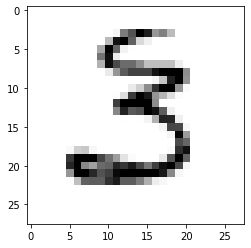




Label: 1
Prediction (signle layer model) :  1
Prediction (multi layer model) :  1


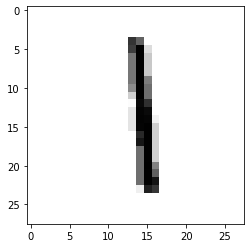




Label: 8
Prediction (signle layer model) :  8
Prediction (multi layer model) :  8


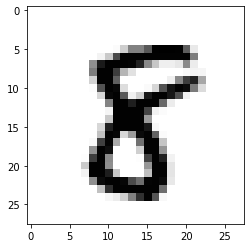




Label: 1
Prediction (signle layer model) :  1
Prediction (multi layer model) :  1


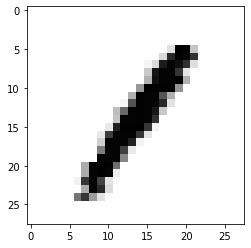




Label: 4
Prediction (signle layer model) :  4
Prediction (multi layer model) :  4


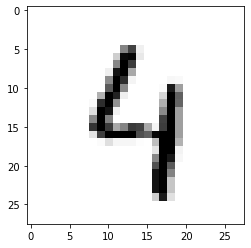

In [6]:
# visualization
import matplotlib.pyplot as plt
import random

for i in range(5):
  r = random.randint(0, len(mnist_test)-1) # 0~9999까지 랜덤한 정수
  X_single_data = mnist_test.data[r].view(-1, 28*28).float().to(device)
  Y_single_data = mnist_test.targets[r].to(device)

  print('Label:', Y_single_data.item())
  single_prediction = model(X_single_data)
  single_prediction2 = model2(X_single_data)
  print('Prediction (signle layer model) : ', torch.argmax(single_prediction, 1).item())
  print('Prediction (multi layer model) : ', torch.argmax(single_prediction2, 1).item())

  plt.imshow(mnist_test.data[r].view(28,28), cmap='Greys', interpolation='nearest')
  plt.show()

  print('\n\n')